In [1]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state
from ACS_data import colname_mask
import re
import pickle
import requests
pd.set_option('display.max_columns', None)

In [2]:
class endpoint_graph():
    def __init__(self, gdict=None):
        if gdict==None:
            gdict = []
        self.gdict = gdict

    
        
        

In [36]:
# http://jeffreyfossett.com/2017/05/07/querying-usa-spending-python.html

# goal of this function is to get
# 1. Covid only relief spending (def_codes)
# 2. Filtered by department/agency
# 3. In a dream world we have businesses and hospital per county as well. 
#
# Can't get from api/v2/disaster need to go through api/v2/search

def post_usaspending_pages(query='agency', just_health=False):
    
    query_dict = {'agency':'/api/v2/disaster/agency/spending/',
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

    while has_next_page:
        payload =  {
      "filter": {
          "def_codes": ["L", "M", "N", "O", "P", "U"]
      },
      "geo_layer": "county",
     # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
      "scope": "recipient_location",
      "spending_type": "total",
      "pagination": {
                  "limit": 10,
                  "page": page,
                  "sort": "award_count",
                  "order": "desc"
              }
    }


        r = requests.post('https://api.usaspending.gov'+q, json=payload)
        rjson = r.json()
        output+= rjson['results']
        has_next_page = rjson['page_metadata']['hasNext']
        page+=1
        print(r.status_code, page)
    return output

def post_usaspending(query='agency', just_health=False):
    
    query_dict = {
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

    payload =  {
  "filter": {
      "def_codes": ["L", "M", "N", "O", "P", "U"]
  },
  "geo_layer": "county",
 # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
  "scope": "recipient_location",
  "spending_type": "obligation"
}


    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    rjson = r.json()
    output+= rjson['results']
    #has_next_page = rjson['page_metadata']['hasNext']
    #page+=1
    print(r.status_code)
    return output

In [51]:
has_next_page = True
page = 1
output = []

while has_next_page:
    payload = {
          "filter": {
              "def_codes": ["L", "M", "N", "O", "P", "U"],
              "award_type_codes": ["07", "08"]
          },
          "pagination": {
              "limit": 10,
              "page": page,
              "sort": "award_count",
              "order": "desc"
          },
          "spending_type": "total"
      }


    r= requests.post('https://api.usaspending.gov/api/v2/search/new_awards_over_time/', json=payload)
    rjson = r.json()
    has_next_page = rjson['page_metadata']['hasNext']
    page+=1
    output+=rjson['results']
    

KeyError: 'page_metadata'

In [47]:
post_usaspending('dis_geo')

200


[{'amount': 32848306171.16,
  'display_name': 'Los Angeles',
  'shape_code': '06037',
  'population': 10039107,
  'per_capita': 3272.03,
  'award_count': 747836},
 {'amount': 8909569577.95,
  'display_name': 'Miami-Dade',
  'shape_code': '12086',
  'population': 2716940,
  'per_capita': 3279.27,
  'award_count': 423598},
 {'amount': 27132210710.36,
  'display_name': 'Cook',
  'shape_code': '17031',
  'population': 5150233,
  'per_capita': 5268.15,
  'award_count': 398169},
 {'amount': 13480970276.03,
  'display_name': 'Harris',
  'shape_code': '48201',
  'population': 4713325,
  'per_capita': 2860.18,
  'award_count': 280146},
 {'amount': 6607328901.56,
  'display_name': 'Broward',
  'shape_code': '12011',
  'population': 1952778,
  'per_capita': 3383.55,
  'award_count': 226534},
 {'amount': 11492189568.89,
  'display_name': 'Orange',
  'shape_code': '06059',
  'population': 3175692,
  'per_capita': 3618.8,
  'award_count': 219404},
 {'amount': 20469118325.18,
  'display_name': 'New Y

In [18]:
response = post_usaspending()
response

agencies = ['Department of Labor', 'Department of Veterans Affairs', 'Department of Transportation',
           'Department of Health and Human Services', 'Department of Education', 'Department of Housing and Urban Development']

agency_dict = {}
for i in response:
    if i['description'] in agencies:
        agency_dict[i['description']] = {'id':i['id'], 'code':i['code']}
agency_dict

200 2
200 3
200 4
200 5


{'Department of Education': {'id': 1068, 'code': '091'},
 'Department of Housing and Urban Development': {'id': 882, 'code': '086'},
 'Department of Health and Human Services': {'id': 806, 'code': '075'},
 'Department of Transportation': {'id': 731, 'code': '069'},
 'Department of Veterans Affairs': {'id': 561, 'code': '036'},
 'Department of Labor': {'id': 267, 'code': '1601'}}

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}

In [62]:
print(agency_dict)

f = open('agency_dict.pkl', 'wb')
pickle.dump(agency_dict, f)
f.close()

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}


In [65]:
f=open('agency_dict.pkl', 'r+')
agency_dict = pickle.load(f)
agency_dict

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

<BarContainer object of 38 artists>

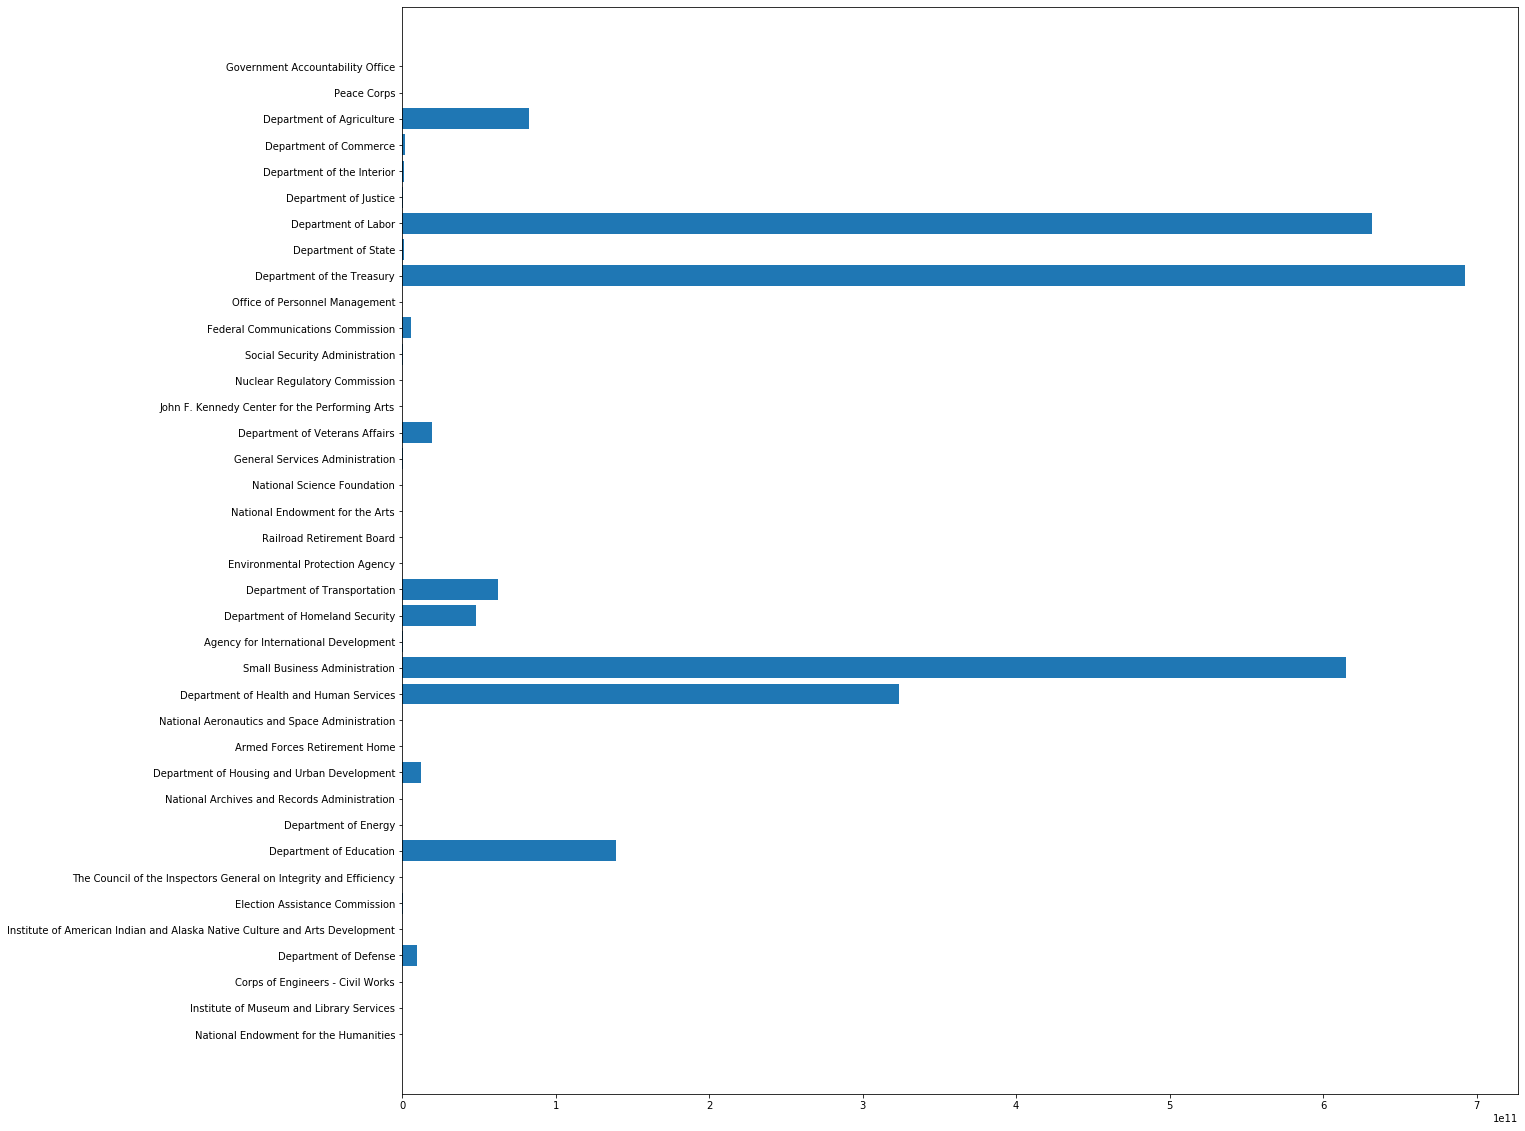

In [19]:
labels = [i['description'] for i in response]
awards = [i['total_budgetary_resources'] for i in response]

plt.figure(figsize=(20,20))
plt.barh(labels,awards)
#plt.xticks(rotation=90)


In [37]:
def geo_search():
    
    q = '/api/v2/search/spending_by_geography/'

    # initialization
    has_next_page = True
    page = 1
    output = []

    #while has_next_page:
    payload =   {
  "filters": {
      #"keywords": ["Filter is required"],
      "agencies":[{
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Health and Human Services"
      },
      {
          "type":"awarding",
          "tier":"toptier",
          "name":"Department Education"
      },
      {
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Housing and Urban Development"
      }], 
      "time_period":[{
          "start_date":"2020-02-06",
          "end_date":"2021-03-01"
      }]
  },
  "scope": "recipient_location",
  "geo_layer": "county"
}

    r = requests.post('https://api.usaspending.gov'+q, json=payload)
   # print(r.text)
    rjson = r.json()
   # print(rjson)
    output+= rjson['results']
   # has_next_page = rjson['page_metadata']['hasNext']
    #page+=1
    print(r.status_code, page)
    return output

In [38]:
# With Dep Health Suffolk "aggregated_amount":19440707238.44
# With Dep Health Suffolk "aggregated_amount":172477803663.77
#geo_dep_health = geo_search()
geo_dep_health = post_usaspending('dis_geo')

200


In [35]:
geo_dep_health['results'][0]

{'amount': 32848306171.16,
 'display_name': 'Los Angeles',
 'shape_code': '06037',
 'population': 10039107,
 'per_capita': 3272.03,
 'award_count': 747836}

In [32]:
{'amount': 32848306171.16,
   'display_name': 'Los Angeles',
   'shape_code': '06037',
   'population': 10039107,
   'per_capita': 3272.03,
   'award_count': 747836},

{'shape_code': '25025',
 'aggregated_amount': 19440707238.44,
 'display_name': 'Suffolk',
 'population': 803907,
 'per_capita': 24182.78}

In [40]:

init_data = {'shape_code': [i['shape_code'] for i in geo_dep_health[:]],
 'amount': [i['amount'] for i in geo_dep_health[:]],
 'display_name': [i['display_name'] for i in geo_dep_health[:]],
 'population': [i['population'] for i in geo_dep_health[:]],
 'per_capita': [i['per_capita'] for i in geo_dep_health[:]]}#,
 #'award_count': [i['award_count'] for i in geo_dep_health[:]]}


#init_data = geo_dep_health[0]
gdh_df = pd.DataFrame(data=init_data)


#gdh_df = pd.read_json(geo_dep_health.json())

In [41]:
gdh_df[gdh_df.per_capita<0]

,shape_code,amount,display_name,population,per_capita


In [43]:

def spend_county_state_map(spending, ACS, covid):
    spend = copy.deepcopy(spending)
    spend['State'] = ''
    val_count = spend['county_name'].value_counts()
    dupes = [i for i in val_count.index if val_count[i]!=1]
    for idx in spend.index:
        if spend.loc[idx, 'county_name'] in dupes:
            # Get a subset of the ACS data that matches entry county name
            ACS_sub = ACS[ACS['county_name']==spend.loc[idx, 'county_name']][['county_name','tot','State']]
            # calculate the difference between spend entry and ACS populations
            ACS_sub['diffs'] = np.abs(spend.loc[idx, 'population']-ACS_sub['tot'])
            # assign the lowest difference to the spending df
            #try:
            spend.loc[idx,'State']= ACS_sub[ACS_sub['diffs']==min(ACS_sub['diffs'])]['State'].values[0]
            #except:
                #spend.loc[idx,'State']= 'Missing'
                
            # Current implementation allows for multiple entries of the same county into different records
            # in the spending df which is impossible. Consider implementing a low pass filter with the
            # alternative case being unknown or a counter for number of assignments
            
        else:
            val = spend['county_name'][idx]
            #print(val)
            #print(covid[covid['county_name']==val].State.values[0])
            #print(spend.head())
           # try:
            spend.loc[idx, 'State'] = covid[covid['county_name']==val].State.values[0]
           # except:
                #spend.loc[idx, 'State'] = 'Missing'
    
    return spend


In [44]:
test = spend_county_state_map(county_spending, ACS_data, covid_cases)

NameError: name 'county_spending' is not defined